In [1]:
%matplotlib inline
from dl_toolbox.utils import show_detections, unnormalize
import hydra
from omegaconf import OmegaConf
import pytorch_lightning as pl
from dl_toolbox.callbacks import PredictionsVisu
from dl_toolbox.modules import FCOS
from dl_toolbox.networks import ViTDet
import torch
from pprint import pformat
import numpy as np
import itertools



def gpu_mem_used():
    free, total = torch.cuda.mem_get_info(torch.device('cuda:0'))
    mem_used_MB = (total - free) / 1024 ** 2
    return mem_used_MB

/d/pfournie/dl_toolbox/venv38/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/d/pfournie/dl_toolbox/venv38/lib/python3.8/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [7]:
model = ViTDet(
    backbone=cfg.module.model.backbone,
    out_channels=cfg.module.model.out_channels,
    add_extra_blocks=cfg.module.model.add_extra_blocks,
    num_classes=len(datamodule.class_list)
)

module_state_dict = torch.load(
    '/data/outputs/xview/2025-02-05_205903/0/checkpoints/last.ckpt',
    #weights_only=True
)['state_dict']

def remove_prefix(text, prefix):
    # Reproduces python3.9 str.removeprefix()
    return text[text.startswith(prefix) and len(prefix):]
model_state_dict = {remove_prefix(key, 'model.'): val for key, val in module_state_dict.items() if key.startswith('model')}

model.load_state_dict(model_state_dict)
model.to('cuda')
model.eval()

anchors, anchor_sizes = FCOS.get_anchors(model, 672, [128, 256, 512])

datamodule.prepare_data()
datamodule.setup(stage='fit')

/tmp/ipykernel_312905/2759533035.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  module_state_dict = torch.load(


loading annotations into memory...
Done (t=2.79s)
creating index...
index created!


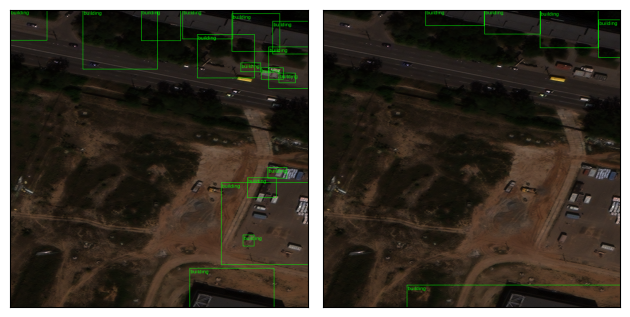

In [18]:
elem = datamodule.val_set[5]
x = elem['image'][None].to('cuda')
int_imgs = unnormalize(x.detach().cpu())
with torch.no_grad():
    cls_logits, bbox_reg, centerness = model(x)
    b,c,h,w = x.shape           
    preds = FCOS.post_process_batch(
        cls_logits.detach(),
        bbox_reg.detach(),
        centerness.detach(),
        (h,w),
        anchors.to('cuda'),
        pre_nms_thresh=0.2,
        pre_nms_top_n=100000,
        nms_thresh=0.1,
        fpn_post_nms_top_n=10000,
        min_size=10,
    )
    preds = [{k: v.detach().cpu() for k, v in p.items()} for p in preds]
show_detections(int_imgs*2, preds+[elem['target']], class_list=datamodule.class_list)

In [6]:
with hydra.initialize(version_base="1.3", config_path="./configs"):
    cfg = hydra.compose(config_name="default_train.yaml", overrides=["+experiment=xview"])

#print(OmegaConf.to_yaml(cfg))
pl.seed_everything(cfg.seed)

datamodule = hydra.utils.instantiate(cfg.datamodule)
module = hydra.utils.instantiate(
    cfg.module,
    class_list=datamodule.class_list
)

class print_val_MAP(pl.Callback):
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.mapmetrics = None
        
    def on_validation_epoch_end(self, trainer, pl_module):
        self.mapmetrics = pl_module.map_metric.compute()
        print(pformat(self.mapmetrics))
        
cfg.trainer.default_root_dir='/data/outputs/trash'

pre_nms_thresh_grid = [0.5]
pre_nms_top_n_grid = [100000]
nms_thresh_grid = np.linspace(0, 0.5, 5)
fpn_post_nms_top_n_grid = [50, 1000]
min_size_grid = [0, 10, 20]

module.pre_nms_thresh=0.5
module.pre_nms_top_n=100000
module.nms_thresh=0.15
module.fpn_post_nms_top_n=1000
module.min_size=10

mapmetrics_grid = []
for thresh, top_n in itertools.product(nms_thresh_grid,fpn_post_nms_top_n_grid):
    module.nms_thresh_grid=thresh
    module.fpn_post_nms_top_n_grid=top_n
    map_cb = print_val_MAP()
    trainer = hydra.utils.instantiate(cfg.trainer)(
        callbacks=[map_cb],
        limit_val_batches=20
    )
    print(f'\n {module.nms_thresh_grid =}, {module.fpn_post_nms_top_n_grid =}')
    trainer.validate(
        module,
        datamodule=datamodule,
        ckpt_path='/data/outputs/xview/2025-02-05_205903/0/checkpoints/last.ckpt',
    )
    mapmetrics_grid.append(map_cb.mapmetrics)

Seed set to 1
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_predict_batches=1.0)` was configured so 100% of the batches will be used..



 module.nms_thresh_grid =0.0, module.fpn_post_nms_top_n_grid =50
loading annotations into memory...
Validation DataLoader 0:  65%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 13/20 [33:10<17:51,  0.01it/s]
Done (t=3.78s)
creating index...
index created!


Restoring states from the checkpoint path at /data/outputs/xview/2025-02-05_205903/0/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /data/outputs/xview/2025-02-05_205903/0/checkpoints/last.ckpt


Validation DataLoader 0:  40%|█████████████████████████████████████████████████████████▌                                                                                      | 8/20 [00:00<00:01,  8.29it/s]

/d/pfournie/dl_toolbox/venv38/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)  # noqa: B028


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  8.58it/s]{'classes': tensor(1, dtype=torch.int32),
 'map': tensor(0.1339),
 'map_50': tensor(0.3760),
 'map_75': tensor(0.0650),
 'map_large': tensor(0.0523),
 'map_medium': tensor(0.1660),
 'map_per_class': tensor(-1.),
 'map_small': tensor(0.0228),
 'mar_1': tensor(0.0079),
 'mar_10': tensor(0.0408),
 'mar_100': tensor(0.2018),
 'mar_100_per_class': tensor(-1.),
 'mar_large': tensor(0.0927),
 'mar_medium': tensor(0.2498),
 'mar_small': tensor(0.0382)}
Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  8.11it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metri

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_predict_batches=1.0)` was configured so 100% of the batches will be used..



 module.nms_thresh_grid =0.0, module.fpn_post_nms_top_n_grid =1000
loading annotations into memory...
Done (t=2.72s)
creating index...
index created!


Restoring states from the checkpoint path at /data/outputs/xview/2025-02-05_205903/0/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /data/outputs/xview/2025-02-05_205903/0/checkpoints/last.ckpt


Validation DataLoader 0:  40%|█████████████████████████████████████████████████████████▌                                                                                      | 8/20 [00:00<00:01,  8.28it/s]

/d/pfournie/dl_toolbox/venv38/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)  # noqa: B028


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  8.51it/s]{'classes': tensor(1, dtype=torch.int32),
 'map': tensor(0.1339),
 'map_50': tensor(0.3760),
 'map_75': tensor(0.0650),
 'map_large': tensor(0.0523),
 'map_medium': tensor(0.1660),
 'map_per_class': tensor(-1.),
 'map_small': tensor(0.0228),
 'mar_1': tensor(0.0079),
 'mar_10': tensor(0.0408),
 'mar_100': tensor(0.2018),
 'mar_100_per_class': tensor(-1.),
 'mar_large': tensor(0.0927),
 'mar_medium': tensor(0.2498),
 'mar_small': tensor(0.0382)}
Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  8.02it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metri

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_predict_batches=1.0)` was configured so 100% of the batches will be used..



 module.nms_thresh_grid =0.125, module.fpn_post_nms_top_n_grid =50
loading annotations into memory...
Done (t=2.67s)
creating index...
index created!


Restoring states from the checkpoint path at /data/outputs/xview/2025-02-05_205903/0/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /data/outputs/xview/2025-02-05_205903/0/checkpoints/last.ckpt


Validation DataLoader 0:  40%|█████████████████████████████████████████████████████████▌                                                                                      | 8/20 [00:00<00:01,  8.24it/s]

/d/pfournie/dl_toolbox/venv38/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)  # noqa: B028


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  8.55it/s]{'classes': tensor(1, dtype=torch.int32),
 'map': tensor(0.1339),
 'map_50': tensor(0.3760),
 'map_75': tensor(0.0650),
 'map_large': tensor(0.0523),
 'map_medium': tensor(0.1660),
 'map_per_class': tensor(-1.),
 'map_small': tensor(0.0228),
 'mar_1': tensor(0.0079),
 'mar_10': tensor(0.0408),
 'mar_100': tensor(0.2018),
 'mar_100_per_class': tensor(-1.),
 'mar_large': tensor(0.0927),
 'mar_medium': tensor(0.2498),
 'mar_small': tensor(0.0382)}
Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  8.06it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metri

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_predict_batches=1.0)` was configured so 100% of the batches will be used..



 module.nms_thresh_grid =0.125, module.fpn_post_nms_top_n_grid =1000
loading annotations into memory...
Done (t=2.77s)
creating index...
index created!


Restoring states from the checkpoint path at /data/outputs/xview/2025-02-05_205903/0/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /data/outputs/xview/2025-02-05_205903/0/checkpoints/last.ckpt


Validation DataLoader 0:  40%|█████████████████████████████████████████████████████████▌                                                                                      | 8/20 [00:00<00:01,  8.25it/s]

/d/pfournie/dl_toolbox/venv38/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)  # noqa: B028


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  8.44it/s]{'classes': tensor(1, dtype=torch.int32),
 'map': tensor(0.1339),
 'map_50': tensor(0.3760),
 'map_75': tensor(0.0650),
 'map_large': tensor(0.0523),
 'map_medium': tensor(0.1660),
 'map_per_class': tensor(-1.),
 'map_small': tensor(0.0228),
 'mar_1': tensor(0.0079),
 'mar_10': tensor(0.0408),
 'mar_100': tensor(0.2018),
 'mar_100_per_class': tensor(-1.),
 'mar_large': tensor(0.0927),
 'mar_medium': tensor(0.2498),
 'mar_small': tensor(0.0382)}
Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  8.00it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metri

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_predict_batches=1.0)` was configured so 100% of the batches will be used..



 module.nms_thresh_grid =0.25, module.fpn_post_nms_top_n_grid =50
loading annotations into memory...
Done (t=2.68s)
creating index...
index created!


Restoring states from the checkpoint path at /data/outputs/xview/2025-02-05_205903/0/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /data/outputs/xview/2025-02-05_205903/0/checkpoints/last.ckpt


Validation DataLoader 0:  40%|█████████████████████████████████████████████████████████▌                                                                                      | 8/20 [00:00<00:01,  8.39it/s]

/d/pfournie/dl_toolbox/venv38/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)  # noqa: B028


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  8.60it/s]{'classes': tensor(1, dtype=torch.int32),
 'map': tensor(0.1339),
 'map_50': tensor(0.3760),
 'map_75': tensor(0.0650),
 'map_large': tensor(0.0523),
 'map_medium': tensor(0.1660),
 'map_per_class': tensor(-1.),
 'map_small': tensor(0.0228),
 'mar_1': tensor(0.0079),
 'mar_10': tensor(0.0408),
 'mar_100': tensor(0.2018),
 'mar_100_per_class': tensor(-1.),
 'mar_large': tensor(0.0927),
 'mar_medium': tensor(0.2498),
 'mar_small': tensor(0.0382)}
Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  8.11it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metri

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_predict_batches=1.0)` was configured so 100% of the batches will be used..



 module.nms_thresh_grid =0.25, module.fpn_post_nms_top_n_grid =1000
loading annotations into memory...
Done (t=2.70s)
creating index...
index created!


Restoring states from the checkpoint path at /data/outputs/xview/2025-02-05_205903/0/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /data/outputs/xview/2025-02-05_205903/0/checkpoints/last.ckpt


Validation DataLoader 0:  40%|█████████████████████████████████████████████████████████▌                                                                                      | 8/20 [00:00<00:01,  8.18it/s]

/d/pfournie/dl_toolbox/venv38/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)  # noqa: B028


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  8.32it/s]{'classes': tensor(1, dtype=torch.int32),
 'map': tensor(0.1339),
 'map_50': tensor(0.3760),
 'map_75': tensor(0.0650),
 'map_large': tensor(0.0523),
 'map_medium': tensor(0.1660),
 'map_per_class': tensor(-1.),
 'map_small': tensor(0.0228),
 'mar_1': tensor(0.0079),
 'mar_10': tensor(0.0408),
 'mar_100': tensor(0.2018),
 'mar_100_per_class': tensor(-1.),
 'mar_large': tensor(0.0927),
 'mar_medium': tensor(0.2498),
 'mar_small': tensor(0.0382)}
Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.86it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metri

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_predict_batches=1.0)` was configured so 100% of the batches will be used..



 module.nms_thresh_grid =0.375, module.fpn_post_nms_top_n_grid =50
loading annotations into memory...
Done (t=2.64s)
creating index...
index created!


Restoring states from the checkpoint path at /data/outputs/xview/2025-02-05_205903/0/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /data/outputs/xview/2025-02-05_205903/0/checkpoints/last.ckpt


Validation DataLoader 0:  40%|█████████████████████████████████████████████████████████▌                                                                                      | 8/20 [00:00<00:01,  8.28it/s]

/d/pfournie/dl_toolbox/venv38/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)  # noqa: B028


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  8.46it/s]{'classes': tensor(1, dtype=torch.int32),
 'map': tensor(0.1339),
 'map_50': tensor(0.3760),
 'map_75': tensor(0.0650),
 'map_large': tensor(0.0523),
 'map_medium': tensor(0.1660),
 'map_per_class': tensor(-1.),
 'map_small': tensor(0.0228),
 'mar_1': tensor(0.0079),
 'mar_10': tensor(0.0408),
 'mar_100': tensor(0.2018),
 'mar_100_per_class': tensor(-1.),
 'mar_large': tensor(0.0927),
 'mar_medium': tensor(0.2498),
 'mar_small': tensor(0.0382)}
Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.99it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metri

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_predict_batches=1.0)` was configured so 100% of the batches will be used..



 module.nms_thresh_grid =0.375, module.fpn_post_nms_top_n_grid =1000
loading annotations into memory...
Done (t=3.64s)
creating index...
index created!


Restoring states from the checkpoint path at /data/outputs/xview/2025-02-05_205903/0/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /data/outputs/xview/2025-02-05_205903/0/checkpoints/last.ckpt


Validation DataLoader 0:  40%|█████████████████████████████████████████████████████████▌                                                                                      | 8/20 [00:00<00:01,  8.21it/s]

/d/pfournie/dl_toolbox/venv38/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)  # noqa: B028


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  8.42it/s]{'classes': tensor(1, dtype=torch.int32),
 'map': tensor(0.1339),
 'map_50': tensor(0.3760),
 'map_75': tensor(0.0650),
 'map_large': tensor(0.0523),
 'map_medium': tensor(0.1660),
 'map_per_class': tensor(-1.),
 'map_small': tensor(0.0228),
 'mar_1': tensor(0.0079),
 'mar_10': tensor(0.0408),
 'mar_100': tensor(0.2018),
 'mar_100_per_class': tensor(-1.),
 'mar_large': tensor(0.0927),
 'mar_medium': tensor(0.2498),
 'mar_small': tensor(0.0382)}
Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.91it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metri

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_predict_batches=1.0)` was configured so 100% of the batches will be used..



 module.nms_thresh_grid =0.5, module.fpn_post_nms_top_n_grid =50
loading annotations into memory...
Done (t=1.74s)
creating index...
index created!


Restoring states from the checkpoint path at /data/outputs/xview/2025-02-05_205903/0/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /data/outputs/xview/2025-02-05_205903/0/checkpoints/last.ckpt


Validation DataLoader 0:  40%|█████████████████████████████████████████████████████████▌                                                                                      | 8/20 [00:00<00:01,  8.46it/s]

/d/pfournie/dl_toolbox/venv38/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)  # noqa: B028


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  8.60it/s]{'classes': tensor(1, dtype=torch.int32),
 'map': tensor(0.1339),
 'map_50': tensor(0.3760),
 'map_75': tensor(0.0650),
 'map_large': tensor(0.0523),
 'map_medium': tensor(0.1660),
 'map_per_class': tensor(-1.),
 'map_small': tensor(0.0228),
 'mar_1': tensor(0.0079),
 'mar_10': tensor(0.0408),
 'mar_100': tensor(0.2018),
 'mar_100_per_class': tensor(-1.),
 'mar_large': tensor(0.0927),
 'mar_medium': tensor(0.2498),
 'mar_small': tensor(0.0382)}
Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  8.14it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metri

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_predict_batches=1.0)` was configured so 100% of the batches will be used..



 module.nms_thresh_grid =0.5, module.fpn_post_nms_top_n_grid =1000
loading annotations into memory...
Done (t=4.08s)
creating index...
index created!


Restoring states from the checkpoint path at /data/outputs/xview/2025-02-05_205903/0/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /data/outputs/xview/2025-02-05_205903/0/checkpoints/last.ckpt


Validation DataLoader 0:  40%|█████████████████████████████████████████████████████████▌                                                                                      | 8/20 [00:00<00:01,  8.27it/s]

/d/pfournie/dl_toolbox/venv38/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)  # noqa: B028


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  8.38it/s]{'classes': tensor(1, dtype=torch.int32),
 'map': tensor(0.1339),
 'map_50': tensor(0.3760),
 'map_75': tensor(0.0650),
 'map_large': tensor(0.0523),
 'map_medium': tensor(0.1660),
 'map_per_class': tensor(-1.),
 'map_small': tensor(0.0228),
 'mar_1': tensor(0.0079),
 'mar_10': tensor(0.0408),
 'mar_100': tensor(0.2018),
 'mar_100_per_class': tensor(-1.),
 'mar_large': tensor(0.0927),
 'mar_medium': tensor(0.2498),
 'mar_small': tensor(0.0382)}
Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.93it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metri